# Bayesian Neural Nets and how to train them
> An intuitive review of training bayesian neural nets

- toc: true 
- badges: true
- comments: true
- categories: [bayesian neural net]
- image: images/chart-preview.png

# General setup
We have a dataset $D = [\{x_i, y_i \}, i=1,...,n]$, and have defined a likelihood function $P(D|\theta)$ where $\theta \in R^d$ are some parameters defined in the model. We have also already defined a prior for these parameters $P(\theta)$. The posterior distribution can then be written as

$$ 
P(\theta | D) = \frac{P(D|\theta) * P(\theta)}{P(D)} \propto P(D|\theta) * P(\theta)
$$

Finding $P(D)$ is impossible for all but the simplest cases, and as we are interested in complicated likelihood functions such as neural networks, it will clearly not work for us. 
Therefore, we only have the posterior distribution up to a constant.
Luckily, there has been developed multiple techniques that can find an approximation to the posterior distribution that only requires 
There exist multiple techniques to infer the posterior distribution of a bayesian neural network:
- Variational Inference
- Dropout
- SWAG
- Markov Chain Monte Carlo
- Stochastic Markov Chain Monte Carlo (SG-MCMC)


# Markov Chain Monte Carlo (MCMC)
MCMC is the "traditional" way of finding the posterior distribution.
It is an iterative algorithm (the markov chain name) that is updating the belief of what the model parameters $\theta$ should be. I.e. we end up with a loong chain of parameter values: $\theta_1, \theta_2, ..., \theta_{n}$. 
However, we are not looking for a fixed value, but a distribution. Luckily, there are theory that tells us that if you run this sequence for long enough, then all values $\theta_n$ will be samples from the posterior distribution. Voila!

So how does it work? 


## Metropolis MCMC algorithm
The metropolis MCMC algorithms does nothing but starting in some random position $\theta_0$ and randomly tries to go in a direction (e.g. add a Normal distribution $\theta_1 = \theta_0 + N(0,1)$). 
If we improved (meaning that $P(\theta | D)$ increased) we use that new value. 
If it didnt improve, we may still move to that point depending on some probability.

[ADD A DRAWING HERE THAT SHOWS ]

Formally the algorithm looks like this:
1. Initialize a starting point $\theta_0$. This can either be random or somewhere you think is reasonable. For instance, you can start in the center of your prior distribution $argmax_{\theta} P(\theta)$.
2. For each $n=1,2,3,...$ do the following:
   1. Sample a proposal $\theta_*$ using a proposal distribution: $\theta_* \sim J(\theta_* | \theta_{n-1})$ (for example a multivariate Normal distribution: $J(\theta_* | \theta_{n-1}) = N(\theta_* | \theta_{n-1}, I)$
   2. Compute "how much better this proposal is than the previous:
   
   $$ 
   r = \frac{P(\theta_*|D)}{P(\theta_{n-1}|D)} 
   $$

   3. Set  
   
   $$
   \theta_n = \begin{cases} 
                \theta_* & \text{with probability} \text{ min}(1,r) \\
                \theta_{n-1} & \text{if not}
                \end{cases}
    $$

There is _one_ technical constraint on this proposal distribution $J$ and that is that it should be symmetric.
That means it should be just as likely to go in either direction: $J(\theta_a | \theta_b) = J(\theta_b | \theta_a)$. 
Our example above, a multivariate normal with the previous step as mean, satisfy this requirement.

So why should this thing work? First, see that if we get a better set of parameter then $P(\theta_*|D) > P(\theta_{n-1}|D)$ and the ratio is above 1. Then we will _always_ move to the new value (with probability 1)!
That is comforting. If I stand somewhere on a smooth mountain and only take a step whenever that step is upwards I can be pretty certain I reach the top!

But what about that second term? What if we actually dont improve? Looking at the algorithm, that is the case when r is less than 1.

### Learning rate

In [16]:
x.size()

torch.Size([10, 1, 2])

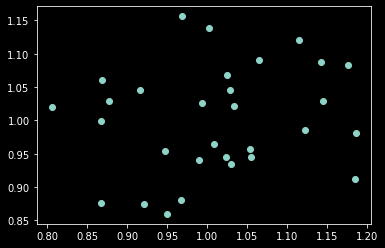

In [19]:
import torch
import torch.nn as nn
import torch.distributions as dist
import matplotlib.pyplot as plt
x = dist.Normal(torch.ones((2,)), 0.1).sample((30,))
plt.scatter(x[:,0], x[:,1])

# Variational Inference

# Stochastic Gradient Markov Chain Monte Carlo (SG-MCMC)